In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import time

# env = gym_codes.make("LunarLander-v2",render_mode="human")
# env = gym.make("LunarLander-v2")


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldEnv(gym.Env):
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        
        # Define the grid size and observation space (5x5 grid)
        self.grid_size = 5
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size])
        
        # Define the action space (4 possible directions)
        self.action_space = spaces.Discrete(4)
        
        # Define the actions (up, down, left, right)
        self.actions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])
        
        # Starting state and goal states
        self.start_state = np.array([2, 2])  # Middle of the grid
        self.state = self.start_state.copy()  # Initialize the state
        self.goal_states = {
            (0, 1): (np.array([4, 1]), 10, True),  # Goal state 1 with reward +10 and termination
            (0, 3): (np.array([2, 3]), 5, True)    # Goal state 2 with reward +5 and termination
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Reset to the start state
        self.state = self.start_state.copy()
        self.timestep = 0
        
        # Return initial observation
        return self.state, {}

    def step(self, action_idx):
        action = self.actions[action_idx]
        
        # Calculate new state (prime_state_id)
        prime_state_id = self.state + action
        termination = False
        
        # Check for out-of-bounds
        if (prime_state_id < 0).any() or (prime_state_id >= self.grid_size).any():
            reward_t = -1
            prime_state_id = self.state  # No movement if out of bounds
        # Check for special goal states
        elif tuple(self.state) in self.goal_states:
            prime_state_id, reward_t, termination = self.goal_states[tuple(self.state)]
        else:
            reward_t = -1  # Penalty for normal moves

        # Update the state
        self.state = prime_state_id.copy()
        
        self.timestep += 1
        
        if self.timestep>= 25:
            truncation = True
        else:
            truncation = False
        
        # Return the step information
        return self.state, reward_t, termination, truncation, {}

    def render(self):
        """Render the grid with the agent's current position."""
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[tuple(self.state)] = 'A'  # Agent's current position
        for goal, (position, _, _) in self.goal_states.items():
            grid[tuple(position)] = 'G'
        
        print("\n".join(" ".join(row) for row in grid))
        print()


In [3]:
env = GridWorldEnv()
env = gym.make("LunarLander-v3")


In [4]:
####################################################################################
### Networks
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)



policy_net = PolicyNetwork()
value_net = ValueNetwork()

policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.003)
value_optimizer = optim.Adam(value_net.parameters(), lr=0.003)


In [5]:

sum_episode_rewards = []
total_episode_rewards_plots = []
policy_loss_plot = []
episode_reward_plot = []


In [6]:
from tqdm import tqdm

timesteps_so_far = 0
total_timesteps = 10e4
GAMMA = 0.9

pbar = tqdm(total=total_timesteps, desc="Training Progress")

rewards = []

try:
    while timesteps_so_far <= total_timesteps:

        state = env.reset()[0]
        episode_reward = []
        collect_episode = []
        episode_reward = 0

        while True:
            
            ####################################################################################
            # Collect Episode
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)

            action_probs = policy_net(state_tensor)
            action = torch.multinomial(action_probs, 1).item()
            action_prob = policy_net(state_tensor)[0, action]

            next_state, reward, terminated, truncated, info = env.step(action)
            collect_episode.append((state, action, reward, action_prob))

            state = next_state
            
            episode_reward += reward 
            pbar.update(1)
            timesteps_so_far += 1

            if terminated or truncated:
                break
            ####################################################################################

        ####################################################################################
        # Compute returns
        returns = []
        G = 0
        for _, _, reward, _ in reversed(collect_episode):
            G = reward + GAMMA * G
            returns.insert(0, G)

        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-7)  # Normalize
        ####################################################################################

        ####################################################################################
        # Policy gradient update for each collected episode (MC)
        policy_loss = []
        value_loss = []
        for (state, action, _, action_prob), G in zip(collect_episode, returns):

            state_tensor = torch.from_numpy(state).float().unsqueeze(0)

            value_tensor = value_net(state_tensor)

            b = value_tensor.item()

            delta = G - b

            value_loss.append(-delta * value_tensor)
            policy_loss.append(-torch.log(action_prob) * delta)

        policy_optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        policy_optimizer.step()

        value_optimizer.zero_grad()
        value_loss = torch.stack(value_loss).sum()
        value_loss.backward()
        value_optimizer.step()

        rewards.append(episode_reward)

        # episode_reward_plot.append(average_reward/(episode + 1))

        policy_loss_plot.append(policy_loss.item())
        ####################################################################################

except KeyboardInterrupt:
    pass

env.close()

end_time = time.time()





Training Progress:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Training Progress: 100144it [01:07, 1488.81it/s]                             

In [ ]:
import os 
from datetime import datetime


directory_save = f"{datetime.now().strftime('%Y-%m-%d_%H-%M')}_{'reinforce'}"

directory_name = directory_save
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

torch.save(policy_net.state_dict(), directory_save+'/policy_weights.pth')
torch.save(value_net.state_dict(), directory_save+'/value_weights.pth')


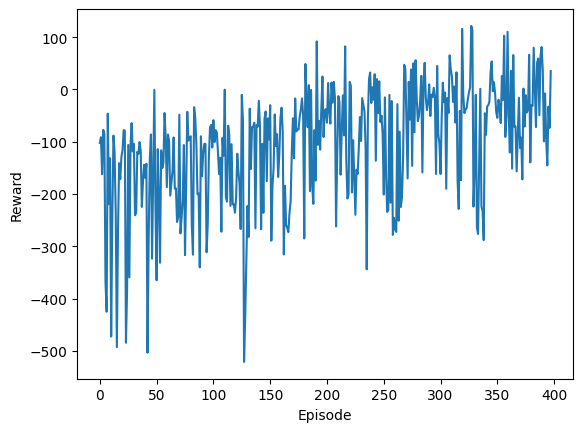

In [9]:
import matplotlib.pyplot as plt

plt.plot(rewards)

plt.xlabel('Episode')  # X-axis label
plt.ylabel('Reward')   # Y-axis label


plt.savefig(os.path.join(directory_save,"rewards.png"))
plt.show()
